#  mnist fashion L-layer neural network in tensorflow


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL as Image
import math
from scipy.misc import imread, imresize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [2]:
data_train = pd.read_csv("/home/pranav/Downloads/fashionmnist/fashion-mnist_train.csv")
Y_train = np.array(data_train['label'])
X_train = np.array(data_train.iloc[:,1:785])
data_test = pd.read_csv("/home/pranav/Downloads/fashionmnist/fashion-mnist_test.csv")
Y_test = np.array(data_test['label'])
X_test = np.array(data_test.iloc[:,1:785])
print (X_train.shape,Y_train.shape)
pca=PCA(n_components=256)
X_train_pc=pca.fit(X_train).transform(X_train)

#print (type(x_train_pc))
print(sum(pca.explained_variance_ratio_)) #what is cumsum variance?
print(X_train_pc.shape)
pca = PCA(n_components=256)
X_testpc=pca.fit(X_test).transform(X_test)
print (sum(pca.explained_variance_ratio_))
print(X_testpc.shape)




(60000, 784) (60000,)
0.9658580971914587
(60000, 256)
0.9674952226518075
(10000, 256)


(60000, 784)
(784,)


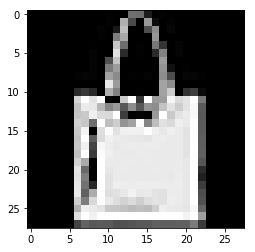

In [3]:
firstimage=X_train[65].reshape(28,28)
print (X_train.shape)
print (X_train[1].shape)
plt.imshow(firstimage,cmap="gray")

# print(X_train_pc[1])

# This is reduced form of the training data from (60000,784) to (60000,256)

<class 'numpy.ndarray'>
(60000, 256)


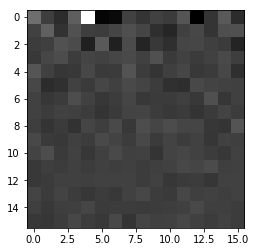

In [4]:
applied_pcaimage = X_train_pc[65].reshape(16,16)
plt.imshow(applied_pcaimage,cmap="gray")
print (type(X_train_pc))
print (X_train_pc.shape)

# Creating a program in tensorflow steps-:
## step 1:creating a graph containing Tensor (creating variables , placeholders,operators etc)
## step 2:create a session 
## step 3:initialize the session 
## step 4:run the session


In [5]:
def create_placeholder(X_dims,Y_dims):
    X = tf.placeholder(tf.float32,shape=[X_dims,None],name="X")
    Y = tf.placeholder(tf.float32,shape=[Y_dims,None],name="Y")
    return X,Y

In [6]:
def initialize_weights(layer_dims):
    L=len(layer_dims)
    tf.set_random_seed(1)
    parameter={}
    for l in range(1,L):
        parameter["W"+str(l)] = tf.get_variable("W"+str(l),shape=[layer_dims[l],layer_dims[l-1]],initializer=tf.contrib.layers.xavier_initializer()) 
        parameter["b"+str(l)] = tf.get_variable("b"+str(l),shape=[layer_dims[l],1],initializer=tf.zeros_initializer())
        
    return parameter
        


In [7]:
def forward_prop(X,parameters):
    L=len(parameters)//2
    Z_forward={}
    X = tf.cast(X,dtype = tf.float32)
    A_prev = X
    for l in range(L):
        
        Z_forward["Z"+str(l+1)] =tf.add(tf.matmul(parameters["W"+str(l+1)],A_prev),parameters["b"+str(l+1)])
        A_prev = tf.nn.relu(Z_forward["Z"+str(l+1)])
    return Z_forward["Z"+str(L)]
        
    
    

# converting the Y output to consecutive one_hot_encode(below shown figure is an example of one hot encoding)
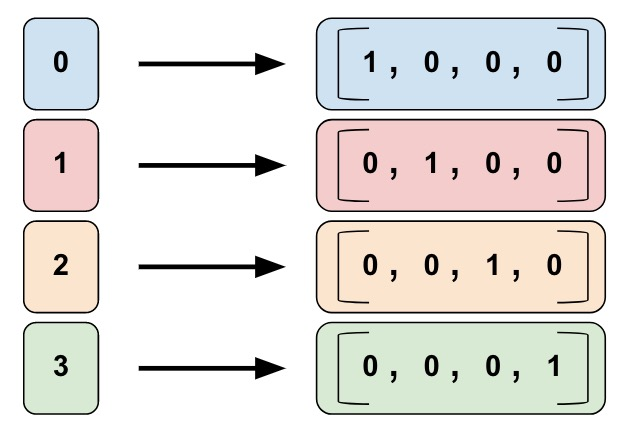

In [8]:
def one_hot_encode(labels,C):
    Y=tf.one_hot(labels,C,axis=0)
    sess=tf.Session()
    one_hot=sess.run(Y)
    sess.close()
    return one_hot
    

Computing error of the neural network

In [10]:
def compute_cost(ZL,Y):
    labels=tf.transpose(Y)
    logits=tf.transpose(ZL)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits =logits ,labels=labels))
    return cost
    

Shuffling dataset and converting it into mini batches

In [11]:
def random_mini_batches(X,Y,batch_size,seed):
    m = X.shape[1] #number of training examples
    permutation = list(np.random.permutation(m))
    mini_batches = []
    
    X_shuffled = X[:,permutation]
    Y_shuffled = Y[:,permutation].reshape(Y.shape[0],m)
    number_of_minibatches = math.floor(m/batch_size)
    for l in range(number_of_minibatches):
        X_mini_batch = X_shuffled[:,l*batch_size:(l+1)*batch_size]
        Y_mini_batch = Y_shuffled[:,l*batch_size:(l+1)*batch_size]
        mini_batch = (X_mini_batch,Y_mini_batch)
        mini_batches.append(mini_batch)
        
    if m%batch_size !=0:
        X_mini_batch = X_shuffled[:,number_of_minibatches*batch_size:m]
        Y_mini_batch = Y_shuffled[:,number_of_minibatches*batch_size:m]
        mini_batch = (X_mini_batch,Y_mini_batch)
        mini_batches.append(mini_batch)
    return mini_batches

In [12]:
Xtrain = (X_train.T)/255 # shape is 256*60000
print (Xtrain.shape)
Ytrain = one_hot_encode(Y_train,10)
print (Ytrain.shape)
Xtest = (X_test.T)/255
Ytest = one_hot_encode(Y_test,10) 
print (Ytest.shape)
print (Xtest.shape)

(784, 60000)
(10, 60000)
(10, 10000)
(784, 10000)


In [13]:
X_lessdimstrain = (X_train_pc.T)/255
Y_pctr = Ytrain
X_lessdimstest = (X_testpc.T)/255
Y_pctst =Ytest
print(X_lessdimstrain.shape,Y_pctr.shape,X_lessdimstest.shape,Y_pctst.shape)

(256, 60000) (10, 60000) (256, 10000) (10, 10000)


In [19]:
def NN_model(Xtrain_,Ytrain_,Xtest_,Ytest_,layer_dims,learning_rate,epsilon,beta1,beta2,num_epochs):
 
    tf.reset_default_graph()
    tf.set_random_seed(1) 
    seed=1
    (X_dims,m) = Xtrain_.shape
    Y_dims = Ytrain_.shape[0]
    X,Y = create_placeholder(X_dims,Y_dims)
    parameter = initialize_weights(layer_dims)
    costs=[]
    Zl = forward_prop(X,parameter)
    cost = compute_cost(Zl,Y)
   
    optimizer = tf.train.AdamOptimizer(learning_rate,beta1,beta2,epsilon,name="Adam").minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epch in range(num_epochs):
            seed = seed + 1
            epch_cost = 0
            batch_size = 64
            num_minibatches = int(m / batch_size)
            mini_batches_random = random_mini_batches(Xtrain_,Ytrain_,batch_size,seed)
            
            for minibatches in mini_batches_random:
                (mini_batchX,mini_batchY) = minibatches
                optimizrAda,mini_batchcost = sess.run([optimizer,cost],feed_dict={X:mini_batchX,Y:mini_batchY})
                epch_cost += (mini_batchcost/num_minibatches)
            if epch%10==0:
                print ("number of epoch %i:%f"%(epch,epch_cost))
                costs.append(epch_cost)
            plt.plot(np.squeeze(costs))
            plt.title("loss with respect to number of iteration")
            plt.xlabel("loss per 10 iteration")
            plt.ylabel("loss")
        parameter = sess.run(parameter)
        correct_prediction = tf.equal(tf.argmax(Zl), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: Xtrain_, Y: Ytrain_})
        test_accuracy = accuracy.eval({X: Xtest_, Y: Ytest_})
        print ("Train Accuracy:", train_accuracy)
        print ("Test Accuracy:", test_accuracy )
        
           
        return parameter,train_accuracy,test_accuracy    

In [20]:
layer_dims = [784,200,100,30,20,10]
learning_rate = .0001
beta1 = .9
beta2 = .999
num_epochs = 150
epsilon = 10**(-8)


number of epoch 0:0.799008
number of epoch 10:0.303585
number of epoch 20:0.246970
number of epoch 30:0.206884
number of epoch 40:0.173701
number of epoch 50:0.146169
number of epoch 60:0.124240
number of epoch 70:0.103779
number of epoch 80:0.083548
number of epoch 90:0.068076
number of epoch 100:0.054277
number of epoch 110:0.047629
number of epoch 120:0.039364
number of epoch 130:0.033631
number of epoch 140:0.031366
Train Accuracy: 0.9960667
Test Accuracy: 0.8943


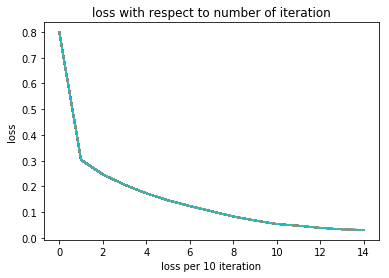

In [21]:
parameter,train_accuracy,test_accuracy = NN_model(Xtrain,Ytrain,Xtest,Ytest,layer_dims,learning_rate,epsilon,beta1,beta2,num_epochs)


In [22]:
print ("accuracy in the training set",train_accuracy)
print ("accuracy in the test set",test_accuracy)


accuracy in the training set 0.9960667
accuracy in the test set 0.8943


Training NN using reduced dimension(Model is overfitting)

number of epoch 0:0.959366
number of epoch 10:0.257850
number of epoch 20:0.180835
number of epoch 30:0.122632
number of epoch 40:0.075847
number of epoch 50:0.040450
number of epoch 60:0.019143
number of epoch 70:0.008027
number of epoch 80:0.008333
number of epoch 90:0.002037
number of epoch 100:0.013759
number of epoch 110:0.013632
number of epoch 120:0.011358
number of epoch 130:0.000290
number of epoch 140:0.014242
Train Accuracy: 1.0
Test Accuracy: 0.4577


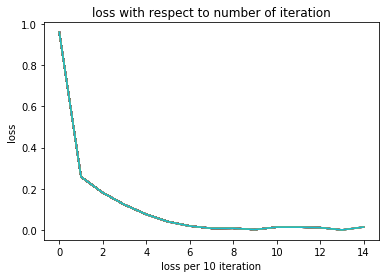

In [23]:
layer_dims = [256,200,100,30,20,10]
learning_rate = .0001
beta1 = .9
beta2 = .999
num_epochs = 150
epsilon = 10**(-8)

parameter,trainpcaccuracy,testpcaccuracy = NN_model(X_lessdimstrain,Y_pctr,X_lessdimstest,Y_pctst,layer_dims,learning_rate,epsilon,beta1,beta2,num_epochs)